In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt # Parameters
import kagglehub

IMAGE_SIZE = 16
PIXEL_LEVELS = 4
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Data Preparation
transform = transforms.Compose([
transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
transforms.ToTensor(),
transforms.Lambda(lambda x: (x * 255).float() // (256 // PIXEL_LEVELS))
])
# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")
dataset = datasets.FashionMNIST(root=path, train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 68.8M/68.8M [00:04<00:00, 17.6MB/s]

Extracting files...



100%|██████████| 26.4M/26.4M [00:02<00:00, 11.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 179kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.22MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 19.8MB/s]


In [11]:
# Masked Convolution Layer
class MaskedConv2d(nn.Conv2d):
  def __init__(self, mask_type, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.register_buffer('mask', self.weight.data.clone())
    _, _, h, w = self.weight.size()
    self.mask.fill_(1)
    self.mask[:, :, h // 2, w // 2 + (mask_type == 'B'):] = 0
    self.mask[:, :, h // 2 + 1:] = 0
  def forward(self, x):
    self.weight.data *= self.mask
    return super().forward(x)

In [12]:
# Residual Block
class ResidualBlock(nn.Module):
  def __init__(self, filters):
    super().__init__()
    self.block = nn.Sequential(
    nn.ReLU(),
    nn.Conv2d(filters, filters // 2, kernel_size=1),
    nn.ReLU(),
    MaskedConv2d('B', filters // 2, filters // 2, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(filters // 2, filters, kernel_size=1)
    )
  def forward(self, x):
    return x + self.block(x)

In [13]:
# PixelCNN Model
class PixelCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
    MaskedConv2d('A', 1, N_FILTERS, kernel_size=7, padding=3),
    *[ResidualBlock(N_FILTERS) for _ in range(RESIDUAL_BLOCKS)],
    nn.ReLU(),
    MaskedConv2d('B', N_FILTERS, N_FILTERS, kernel_size=1),
    nn.ReLU(),
    MaskedConv2d('B', N_FILTERS, N_FILTERS, kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(N_FILTERS, PIXEL_LEVELS, kernel_size=1)
  )
  def forward(self, x):
    return self.model(x)

model = PixelCNN().to(DEVICE)

In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()
# Training Loop
for epoch in range(EPOCHS):
  model.train()
  total_loss = 0
  for images, _ in tqdm(data_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
    images = images.to(DEVICE).squeeze(1)
    optimizer.zero_grad()
    inputs = images.float().unsqueeze(1) # [batch, 1, H, W]
    targets = images.long() # [batch, H, W]
    outputs = model(inputs) # [batch, PIXEL_LEVELS, H, W]
    loss = criterion(outputs, targets) # CrossEntropy expects float inputs and long targets
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  avg_loss = total_loss / len(data_loader)
  print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

Epoch 1/100: 100%|██████████| 469/469 [00:22<00:00, 20.97it/s]


Epoch 1, Loss: 0.2834


Epoch 2/100: 100%|██████████| 469/469 [00:22<00:00, 21.12it/s]


Epoch 2, Loss: 0.2793


Epoch 3/100: 100%|██████████| 469/469 [00:22<00:00, 21.07it/s]


Epoch 3, Loss: 0.2792


Epoch 4/100: 100%|██████████| 469/469 [00:22<00:00, 21.21it/s]


Epoch 4, Loss: 0.2789


Epoch 5/100: 100%|██████████| 469/469 [00:22<00:00, 21.01it/s]


Epoch 5, Loss: 0.2787


Epoch 6/100: 100%|██████████| 469/469 [00:22<00:00, 21.06it/s]


Epoch 6, Loss: 0.2785


Epoch 7/100: 100%|██████████| 469/469 [00:22<00:00, 21.10it/s]


Epoch 7, Loss: 0.2782


Epoch 8/100: 100%|██████████| 469/469 [00:22<00:00, 21.02it/s]


Epoch 8, Loss: 0.2778


Epoch 9/100: 100%|██████████| 469/469 [00:22<00:00, 20.97it/s]


Epoch 9, Loss: 0.2776


Epoch 10/100: 100%|██████████| 469/469 [00:22<00:00, 21.05it/s]


Epoch 10, Loss: 0.2771


Epoch 11/100: 100%|██████████| 469/469 [00:22<00:00, 21.05it/s]


Epoch 11, Loss: 0.2771


Epoch 12/100: 100%|██████████| 469/469 [00:22<00:00, 20.93it/s]


Epoch 12, Loss: 0.2766


Epoch 13/100: 100%|██████████| 469/469 [00:22<00:00, 20.91it/s]


Epoch 13, Loss: 0.2763


Epoch 14/100: 100%|██████████| 469/469 [00:22<00:00, 20.94it/s]


Epoch 14, Loss: 0.2761


Epoch 15/100: 100%|██████████| 469/469 [00:22<00:00, 21.02it/s]


Epoch 15, Loss: 0.2759


Epoch 16/100: 100%|██████████| 469/469 [00:22<00:00, 21.04it/s]


Epoch 16, Loss: 0.2756


Epoch 17/100: 100%|██████████| 469/469 [00:21<00:00, 21.34it/s]


Epoch 17, Loss: 0.2753


Epoch 18/100: 100%|██████████| 469/469 [00:22<00:00, 21.31it/s]


Epoch 18, Loss: 0.2751


Epoch 19/100: 100%|██████████| 469/469 [00:22<00:00, 21.08it/s]


Epoch 19, Loss: 0.2748


Epoch 20/100: 100%|██████████| 469/469 [00:22<00:00, 21.17it/s]


Epoch 20, Loss: 0.2747


Epoch 21/100: 100%|██████████| 469/469 [00:22<00:00, 21.14it/s]


Epoch 21, Loss: 0.2744


Epoch 22/100: 100%|██████████| 469/469 [00:22<00:00, 21.09it/s]


Epoch 22, Loss: 0.2742


Epoch 23/100: 100%|██████████| 469/469 [00:22<00:00, 21.31it/s]


Epoch 23, Loss: 0.2741


Epoch 24/100: 100%|██████████| 469/469 [00:22<00:00, 21.24it/s]


Epoch 24, Loss: 0.2735


Epoch 25/100: 100%|██████████| 469/469 [00:22<00:00, 21.11it/s]


Epoch 25, Loss: 0.2736


Epoch 26/100: 100%|██████████| 469/469 [00:22<00:00, 21.09it/s]


Epoch 26, Loss: 0.2733


Epoch 27/100: 100%|██████████| 469/469 [00:22<00:00, 20.97it/s]


Epoch 27, Loss: 0.2732


Epoch 28/100: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]


Epoch 28, Loss: 0.2730


Epoch 29/100: 100%|██████████| 469/469 [00:22<00:00, 21.05it/s]


Epoch 29, Loss: 0.2728


Epoch 30/100: 100%|██████████| 469/469 [00:21<00:00, 21.34it/s]


Epoch 30, Loss: 0.2726


Epoch 31/100: 100%|██████████| 469/469 [00:22<00:00, 21.03it/s]


Epoch 31, Loss: 0.2725


Epoch 32/100: 100%|██████████| 469/469 [00:22<00:00, 21.08it/s]


Epoch 32, Loss: 0.2723


Epoch 33/100: 100%|██████████| 469/469 [00:22<00:00, 21.05it/s]


Epoch 33, Loss: 0.2720


Epoch 34/100: 100%|██████████| 469/469 [00:22<00:00, 21.02it/s]


Epoch 34, Loss: 0.2718


Epoch 35/100: 100%|██████████| 469/469 [00:22<00:00, 21.15it/s]


Epoch 35, Loss: 0.2718


Epoch 36/100: 100%|██████████| 469/469 [00:21<00:00, 21.40it/s]


Epoch 36, Loss: 0.2716


Epoch 37/100: 100%|██████████| 469/469 [00:22<00:00, 21.30it/s]


Epoch 37, Loss: 0.2714


Epoch 38/100: 100%|██████████| 469/469 [00:22<00:00, 21.10it/s]


Epoch 38, Loss: 0.2713


Epoch 39/100: 100%|██████████| 469/469 [00:22<00:00, 21.10it/s]


Epoch 39, Loss: 0.2711


Epoch 40/100: 100%|██████████| 469/469 [00:22<00:00, 21.09it/s]


Epoch 40, Loss: 0.2710


Epoch 41/100: 100%|██████████| 469/469 [00:22<00:00, 21.03it/s]


Epoch 41, Loss: 0.2708


Epoch 42/100: 100%|██████████| 469/469 [00:22<00:00, 21.22it/s]


Epoch 42, Loss: 0.2707


Epoch 43/100: 100%|██████████| 469/469 [00:21<00:00, 21.36it/s]


Epoch 43, Loss: 0.2706


Epoch 44/100: 100%|██████████| 469/469 [00:22<00:00, 21.01it/s]


Epoch 44, Loss: 0.2702


Epoch 45/100: 100%|██████████| 469/469 [00:22<00:00, 21.14it/s]


Epoch 45, Loss: 0.2703


Epoch 46/100: 100%|██████████| 469/469 [00:22<00:00, 21.05it/s]


Epoch 46, Loss: 0.2701


Epoch 47/100: 100%|██████████| 469/469 [00:22<00:00, 21.15it/s]


Epoch 47, Loss: 0.2701


Epoch 48/100: 100%|██████████| 469/469 [00:22<00:00, 21.12it/s]


Epoch 48, Loss: 0.2699


Epoch 49/100: 100%|██████████| 469/469 [00:21<00:00, 21.52it/s]


Epoch 49, Loss: 0.2698


Epoch 50/100: 100%|██████████| 469/469 [00:22<00:00, 21.10it/s]


Epoch 50, Loss: 0.2695


Epoch 51/100: 100%|██████████| 469/469 [00:22<00:00, 21.13it/s]


Epoch 51, Loss: 0.2694


Epoch 52/100: 100%|██████████| 469/469 [00:22<00:00, 21.02it/s]


Epoch 52, Loss: 0.2693


Epoch 53/100: 100%|██████████| 469/469 [00:22<00:00, 21.13it/s]


Epoch 53, Loss: 0.2691


Epoch 54/100: 100%|██████████| 469/469 [00:22<00:00, 21.21it/s]


Epoch 54, Loss: 0.2693


Epoch 55/100: 100%|██████████| 469/469 [00:21<00:00, 21.59it/s]


Epoch 55, Loss: 0.2689


Epoch 56/100: 100%|██████████| 469/469 [00:22<00:00, 21.17it/s]


Epoch 56, Loss: 0.2688


Epoch 57/100: 100%|██████████| 469/469 [00:22<00:00, 20.71it/s]


Epoch 57, Loss: 0.2689


Epoch 58/100: 100%|██████████| 469/469 [00:22<00:00, 21.00it/s]


Epoch 58, Loss: 0.2687


Epoch 59/100: 100%|██████████| 469/469 [00:22<00:00, 20.92it/s]


Epoch 59, Loss: 0.2685


Epoch 60/100: 100%|██████████| 469/469 [00:22<00:00, 20.96it/s]


Epoch 60, Loss: 0.2684


Epoch 61/100: 100%|██████████| 469/469 [00:21<00:00, 21.47it/s]


Epoch 61, Loss: 0.2684


Epoch 62/100: 100%|██████████| 469/469 [00:21<00:00, 21.67it/s]


Epoch 62, Loss: 0.2681


Epoch 63/100: 100%|██████████| 469/469 [00:22<00:00, 21.11it/s]


Epoch 63, Loss: 0.2681


Epoch 64/100: 100%|██████████| 469/469 [00:22<00:00, 21.20it/s]


Epoch 64, Loss: 0.2679


Epoch 65/100: 100%|██████████| 469/469 [00:22<00:00, 21.12it/s]


Epoch 65, Loss: 0.2679


Epoch 66/100: 100%|██████████| 469/469 [00:22<00:00, 21.13it/s]


Epoch 66, Loss: 0.2679


Epoch 67/100: 100%|██████████| 469/469 [00:21<00:00, 21.49it/s]


Epoch 67, Loss: 0.2677


Epoch 68/100: 100%|██████████| 469/469 [00:21<00:00, 21.39it/s]


Epoch 68, Loss: 0.2676


Epoch 69/100: 100%|██████████| 469/469 [00:22<00:00, 21.20it/s]


Epoch 69, Loss: 0.2674


Epoch 70/100: 100%|██████████| 469/469 [00:22<00:00, 21.24it/s]


Epoch 70, Loss: 0.2674


Epoch 71/100: 100%|██████████| 469/469 [00:22<00:00, 21.20it/s]


Epoch 71, Loss: 0.2673


Epoch 72/100: 100%|██████████| 469/469 [00:22<00:00, 21.14it/s]


Epoch 72, Loss: 0.2673


Epoch 73/100: 100%|██████████| 469/469 [00:21<00:00, 21.36it/s]


Epoch 73, Loss: 0.2671


Epoch 74/100: 100%|██████████| 469/469 [00:22<00:00, 21.28it/s]


Epoch 74, Loss: 0.2670


Epoch 75/100: 100%|██████████| 469/469 [00:22<00:00, 21.03it/s]


Epoch 75, Loss: 0.2669


Epoch 76/100: 100%|██████████| 469/469 [00:22<00:00, 21.06it/s]


Epoch 76, Loss: 0.2668


Epoch 77/100: 100%|██████████| 469/469 [00:22<00:00, 21.13it/s]


Epoch 77, Loss: 0.2667


Epoch 78/100: 100%|██████████| 469/469 [00:22<00:00, 21.03it/s]


Epoch 78, Loss: 0.2668


Epoch 79/100: 100%|██████████| 469/469 [00:22<00:00, 21.00it/s]


Epoch 79, Loss: 0.2666


Epoch 80/100: 100%|██████████| 469/469 [00:22<00:00, 20.78it/s]


Epoch 80, Loss: 0.2665


Epoch 81/100: 100%|██████████| 469/469 [00:22<00:00, 20.90it/s]


Epoch 81, Loss: 0.2664


Epoch 82/100: 100%|██████████| 469/469 [00:22<00:00, 21.01it/s]


Epoch 82, Loss: 0.2663


Epoch 83/100: 100%|██████████| 469/469 [00:22<00:00, 21.22it/s]


Epoch 83, Loss: 0.2662


Epoch 84/100: 100%|██████████| 469/469 [00:22<00:00, 21.20it/s]


Epoch 84, Loss: 0.2661


Epoch 85/100: 100%|██████████| 469/469 [00:22<00:00, 20.93it/s]


Epoch 85, Loss: 0.2660


Epoch 86/100: 100%|██████████| 469/469 [00:22<00:00, 21.13it/s]


Epoch 86, Loss: 0.2660


Epoch 87/100: 100%|██████████| 469/469 [00:22<00:00, 21.12it/s]


Epoch 87, Loss: 0.2659


Epoch 88/100: 100%|██████████| 469/469 [00:22<00:00, 20.87it/s]


Epoch 88, Loss: 0.2660


Epoch 89/100: 100%|██████████| 469/469 [00:22<00:00, 21.06it/s]


Epoch 89, Loss: 0.2657


Epoch 90/100: 100%|██████████| 469/469 [00:22<00:00, 21.01it/s]


Epoch 90, Loss: 0.2656


Epoch 91/100: 100%|██████████| 469/469 [00:22<00:00, 20.98it/s]


Epoch 91, Loss: 0.2658


Epoch 92/100: 100%|██████████| 469/469 [00:22<00:00, 21.17it/s]


Epoch 92, Loss: 0.2656


Epoch 93/100: 100%|██████████| 469/469 [00:22<00:00, 21.30it/s]


Epoch 93, Loss: 0.2654


Epoch 94/100: 100%|██████████| 469/469 [00:22<00:00, 21.23it/s]


Epoch 94, Loss: 0.2654


Epoch 95/100: 100%|██████████| 469/469 [00:22<00:00, 21.28it/s]


Epoch 95, Loss: 0.2653


Epoch 96/100: 100%|██████████| 469/469 [00:22<00:00, 21.29it/s]


Epoch 96, Loss: 0.2652


Epoch 97/100: 100%|██████████| 469/469 [00:22<00:00, 21.18it/s]


Epoch 97, Loss: 0.2652


Epoch 98/100: 100%|██████████| 469/469 [00:22<00:00, 21.17it/s]


Epoch 98, Loss: 0.2651


Epoch 99/100: 100%|██████████| 469/469 [00:22<00:00, 21.30it/s]


Epoch 99, Loss: 0.2650


Epoch 100/100: 100%|██████████| 469/469 [00:21<00:00, 21.43it/s]

Epoch 100, Loss: 0.2651


In [21]:
def generate_images(model, num_images, temperature=1.0):
    model.eval()
    generated = torch.zeros(num_images, 1, IMAGE_SIZE, IMAGE_SIZE, device=DEVICE)
    with torch.no_grad():
        for row in range(IMAGE_SIZE):
            for col in range(IMAGE_SIZE):
                logits = model(generated.float())[:, :, row, col] / temperature
                probs = torch.softmax(logits, dim=-1)
                generated[:, 0, row, col] = torch.multinomial(probs, 1).squeeze(-1)
    return generated.cpu().numpy() / PIXEL_LEVELS

# Generate sample images
sample_images = generate_images(model, num_images=10)
print("Generated images shape:", sample_images.shape)

Generated images shape: (10, 1, 16, 16)


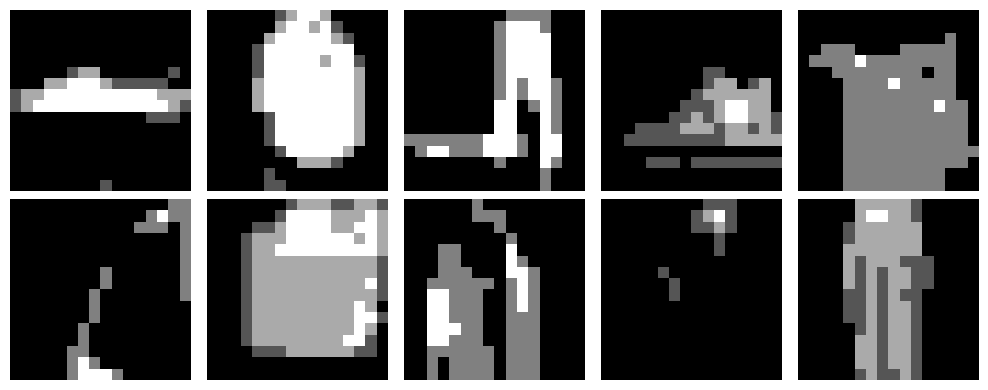

In [22]:
def plot_generated_images(images, n_cols=5):
    n_rows = (len(images) + n_cols - 1) // n_cols
    plt.figure(figsize=(2 * n_cols, 2 * n_rows))

    for idx, img in enumerate(images):
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Generate sample images (assuming you've done this step already)
sample_images = generate_images(model, num_images=10, temperature=1.0)
# Plot generated images
plot_generated_images(sample_images)
